In [1]:
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import random
import string
import json
import re
from collections.abc import Iterable

from matplotlib import pyplot as plt
import plotly.express as px

C:\Users\leona\anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import TweetsUtils
import importlib
importlib.reload(TweetsUtils)
from TweetsUtils import *

### Constants

In [4]:
KEYWORDS = ['febbre', 'brividi', 'dolori alle ossa', 'dolori muscolari', 'malessere generale', 
            'mal di testa', 'mal di gola', 'raffreddore', 'tosse', 'congiuntivite']

In [5]:
base_path = '../flu_tweets/'

tweets_filename = base_path + 'flu_tweets_contents.json'
users_filename = base_path + 'flu_tweets_users.json'
places_filename = base_path + 'flu_tweets_places.json'

### Read files

In [6]:
tweets = read_file(tweets_filename)
users = read_file(users_filename)
places = read_file(places_filename)

print(len(tweets), 'tweets')
print(len(users), 'users')
print(len(places), 'places')

697107 tweets
165663 users
1753 places


In [7]:
for tw in tweets:
    tw['datetime'] = datetime.strptime(tw['datetime'], '%Y-%m-%d %H:%M:%S')

### Filtering

In [8]:
# filter out retweets
tweets = [tw for tw in tweets if not is_retweet(tw)]
print(len(tweets), 'tweets without retweets')

403420 tweets without retweets


In [9]:
# filter out ambiguous tweets (brividi and febbre in combination with at least another keyword)
tweets_brividi = filter_keywords(tweets, 'brividi', KEYWORDS)
tweets_febbre = filter_keywords(tweets, 'febbre', KEYWORDS)

tweets = [tw for tw in tweets 
           if 'brividi' not in tw['text'].lower() 
           and 'febbre' not in tw['text'].lower()]

tweets = tweets + tweets_brividi + tweets_febbre
print(len(tweets), 'tweets without retweets and with adjusted keywords')

140555 tweets without retweets and with adjusted keywords


### Tweets quantity

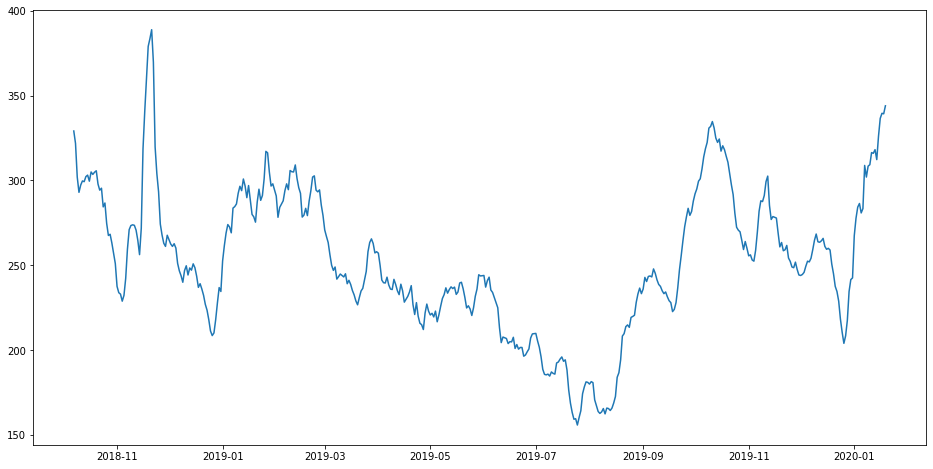

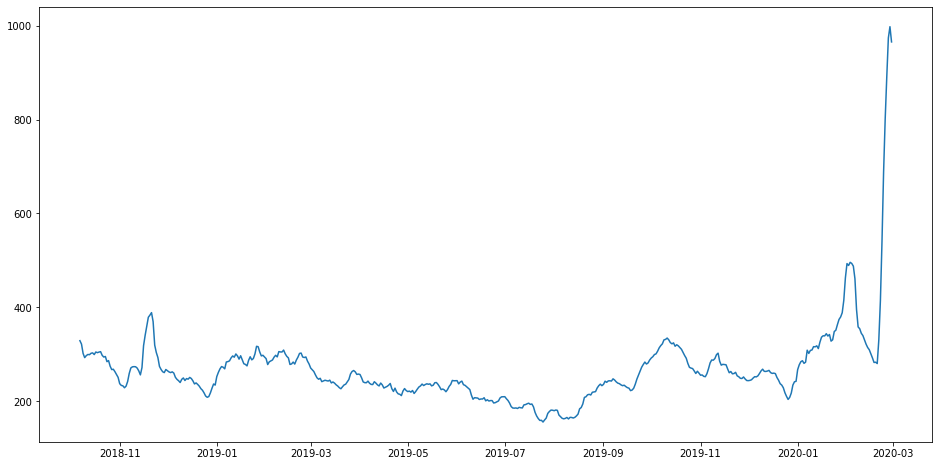

In [10]:
def linechart(tweets, rolling_mean=None, normalize=False):
    s = pd.DataFrame(index=pd.to_datetime([tw['datetime'] for tw in tweets]))
    s['count'] = [1]*len(s)
    s = s.resample('1d').count()
    
    if rolling_mean:
        s['count'] = s.rolling(window=rolling_mean).mean().dropna()
        
    if normalize:
        s['count'] = (s['count'] - s['count'].min()) / (s['count'].max() - s['count'].min())
    
    plt.rcParams["figure.figsize"] = (16,8)
    plt.plot(s)
    plt.show();
    

tweets2 = filter_list(tweets, 'datetime', datetime(2018,10,1), datetime(2020,1,20))
linechart(tweets2, 7)
linechart(tweets, 7)

### Geolocalization

In [13]:
df = get_tweets_with_location(tweets)
df

,datetime,text,lat,lon,name,region,type
30,2018-10-01 01:51:50,"Fa caldo, fa freddo, ho mal di testa da circa ...",41.892770,12.483667,roma,lazio,user_location
1,2018-10-01 04:30:18,"Comunque il raffreddore, i primi giorni di ott...",45.461345,9.159337,Milano,lombardia,geolocalization
29,2018-10-01 04:42:42,La carica dei 70.000 (18.000 secondo le Forze ...,39.293087,16.256099,cosenza,calabria,user_location
0,2018-10-01 04:46:22,Datemi la forza di andare a scuola mezza malat...,43.858716,10.468260,Lucca,toscana,geolocalization
28,2018-10-01 04:50:22,"Buongiorno mondo, mal di gola ""a go go""..........",40.353542,18.171907,"lecce, puglia",puglia,user_location
...,...,...,...,...,...,...,...
5292,2020-02-29 22:15:29,“I bambini sono immuni al vacc... raffreddore”...,44.493820,11.342633,"bologna, emilia romagna",emilia-romagna,user_location
5291,2020-02-29 22:27:15,@SOLIDToM77 Venerdi: abbiamo un problema\nSaba...,43.106758,12.388247,perugia,umbria,user_location
5290,2020-02-29 23:05:46,Auguriamogli di avere un semplice raffreddore....,43.312184,10.519365,"cecina, toscana",toscana,user_location
5289,2020-02-29 23:16:53,mio padre ha un raffreddore mortale ed io mi s...,45.477304,12.254868,torino venezia,veneto,user_location


In [ ]:
# split text for visualization
df['formatted_text'] = df['text'].str.wrap(50).apply(lambda x: x.replace('\n', '<br>'))

# re-group date
group_by = 'month'
if group_by == 'week':
    df['datetime'] = df['datetime'].dt.to_period('W').apply(lambda r: r.start_time)
    df['datetime'] = df['datetime'].astype(str)
elif group_by == 'month':
    df['datetime'] = df['datetime'].dt.to_period('M').apply(lambda r: r.start_time)
    df['datetime'] = df['datetime'].astype(str)

# sort by date
df = df.sort_values(by='datetime')
df

In [ ]:
fig = px.density_mapbox(df, lat=df['lat'], 
                            lon=df['lon'], 
                            radius=10,
                            hover_data={'formatted_text': True, 'name': True, 'lat': False, 'lon': False, 'datetime': False},
                            animation_frame='datetime'
                       )
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=4, mapbox_center = {"lat": 40.9, "lon": 10.9})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 600
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 600
fig.layout.coloraxis.showscale = True   
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t= 10

fig.show()

In [ ]:
x = df[['datetime', 'region', 'text']].groupby(['datetime', 'region']).count().unstack(fill_value=0).stack()
x = x.reset_index()
x.columns = ['month', 'region', 'count']
pop = read_file('files/italy_regions_population.json')
x['normalized_count'] = x.apply(lambda x: 10000*x['count']/pop[x['region']], axis=1)
x

In [ ]:
### https://github.com/deldersveld/topojson
### then converted from topojson to geojson
italy_regions_geo = read_file('files/italy_regions_borders.geojson')

# Choropleth representing the length of region names
fig = px.choropleth(data_frame=x, 
                    geojson=italy_regions_geo, 
                    locations='region', # name of dataframe column
                    featureidkey='properties.NAME_1',  # path to field in GeoJSON feature object with which to match the values passed in to locations
                    color='normalized_count',
                    color_continuous_scale="ylorbr",
                    animation_frame='month',
                    scope="europe",
                    range_color=(0,0.7)#np.max(x['count']))
                   )
fig.update_geos(showcountries=False, showcoastlines=False, showland=True, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, dragmode=False)
fig.show()

In [ ]:
for reg in set(x['region']):
    tmp = x[x['region']==reg]
    plt.plot(tmp['normalized_count'])

plt.show();

### Dati ufficiali

In [ ]:
# https://www.who.int/tools/flunet
filename = 'files/FluNetInteractiveReport.csv'

official = pd.read_csv(filename)
for field in ['Country', 'WHOREGION', 'FLUREGION']:
    del official[field]
    
c = official.columns
official = official[list(c[:5]) + list(c[-3:])]
official.columns = ['year', 'week', 'start_date', 'end_date', 'number_specimen', 'all_positive_viruses', 'all_negative_viruses', 'activity']

official = official.fillna(0)
official

In [ ]:
tmp = official[['start_date', 'number_specimen']].copy()
tmp = tmp.set_index('start_date')
tmp.index = pd.to_datetime(tmp.index)

tmp = tmp['2018-10-01':'2020-01-20']

tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())

tmp

In [ ]:
plt.plot(tmp)
linechart(tweets2, 7, normalize=True)